## Lab 3. Detección de Malware

### Miembros
* Fernanda Esquivel - 21542
* Andrés Montoya - 21552

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-04)

# Creación del dataset

In [67]:
import os
import pandas as pd
import numpy as np
import pefile
import hashlib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from datetime import datetime
import shutil
import subprocess
warnings.filterwarnings('ignore')

### 0. Desempaquetar los archivos

In [68]:
unpacked_dir = "unpacked/"

In [69]:
# 0. Desempaquetar los archivos
def check_if_packed(file_path):
    print("\nAnalyzing file: ", os.path.basename(file_path))
    print("=" * 50)
    # known packers
    suspicious_sections = ['.UPX', 'UPX', '.pak', 'pec2', '.ASPack', '.adata']
    pe = pefile.PE(file_path)
    counter = 0
    for section in pe.sections:
        print(section.Name, 
              hex(section.VirtualAddress), 
              hex(section.Misc_VirtualSize), 
              section.SizeOfRawData)
        
        section_name = section.Name.decode().rstrip('\x00')
        if any(sus in section_name for sus in suspicious_sections):
            counter += 1
    if counter > 0:
        return True
    else:
        return False

def unpackFile(file_path):
    subprocess.run([r"C:\Users\monto\OneDrive\Documents\UVG\Malware\upx-5.0.0-win64\upx-5.0.0-win64\upx.exe", "-d", file_path, "-o", os.path.join(unpacked_dir, os.path.basename(file_path))])

In [70]:
if not os.path.exists(unpacked_dir):
    os.makedirs(unpacked_dir)

    for file in os.listdir("malwr/MALWR"):
        file_path = os.path.join("malwr/MALWR/", file)
        if check_if_packed(file_path):
            print("File is packed, unpacking...")
            unpackFile(file_path)
        else:
            shutil.copy(file_path, unpacked_dir)

In [71]:
# 1. Creación del dataset mediante análisis estático (enfocado)
def getFileHash(file_path):
    """Calcular el hash MD5 de un archivo."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [72]:
def getPEFeatures(file_path):
    """Extraer características estáticas clave de un archivo PE."""
    features = {}
    
    # Metadatos básicos del archivo
    features['file_name'] = os.path.basename(file_path)
    features['file_size'] = os.path.getsize(file_path)
    features['md5'] = getFileHash(file_path)
    
    try:
        pe = pefile.PE(file_path)
        
        #Secciones
        section_names = []
        section_entropies = []
        
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                section_names.append(name)
                
                #Calcular entropía de la sección
                entropy = 0
                if len(section.get_data()) > 0:
                    byte_counts = {}
                    for byte in section.get_data():
                        if isinstance(byte, int):  # Para Python 3
                            byte_counts[byte] = byte_counts.get(byte, 0) + 1
                        else:  # Para Python 2
                            byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                    
                    for count in byte_counts.values():
                        probability = float(count) / len(section.get_data())
                        entropy -= probability * np.log2(probability)
                
                section_entropies.append(entropy)
        
        features['section_names'] = '|'.join(section_names)
        features['number_of_sections'] = len(section_names)
        
        #DLLs y funciones utilizadas
        imported_dlls = []
        imported_functions_count = 0
        
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                dll_name = entry.dll.decode('utf-8', 'ignore')
                imported_dlls.append(dll_name.lower())
                imported_functions_count += len(entry.imports)
        
        features['imported_dlls'] = '|'.join(imported_dlls)
        features['imported_dlls_count'] = len(imported_dlls)
        features['imported_functions_count'] = imported_functions_count
        
        #Detección de DLLs sospechosas
        suspicious_dlls = ['ws2_32.dll', 'wininet.dll', 'urlmon.dll', 'shell32.dll', 'advapi32.dll']
        suspicious_dll_count = sum(1 for dll in imported_dlls if dll.lower() in suspicious_dlls)
        features['suspicious_dll_count'] = suspicious_dll_count
        
        #Fecha de compilación
        if hasattr(pe, 'FILE_HEADER'):
            timestamp = pe.FILE_HEADER.TimeDateStamp
            try:
                compile_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
                features['compile_date'] = compile_date
                
                #Antigüedad del ejecutable (en días desde la fecha actual)
                days_since_compile = (datetime.now() - datetime.fromtimestamp(timestamp)).days
                features['days_since_compile'] = days_since_compile
            except:
                #Los timestamps son inválidos
                features['compile_date'] = 'Invalid'
                features['days_since_compile'] = -1
        
        #Entropía general del archivo
        if hasattr(pe, 'sections'):
            # Entropía promedio de todas las secciones
            features['avg_entropy'] = np.mean(section_entropies) if section_entropies else 0
            features['max_entropy'] = max(section_entropies) if section_entropies else 0
        
        #Características adicionales
        #Tipo de archivo
        features['is_dll'] = 1 if pe.is_dll() else 0
        features['is_exe'] = 1 if pe.is_exe() else 0
        
        #Arquitectura
        features['is_32bit'] = 1 if pe.FILE_HEADER.Machine == 0x14c else 0
        features['is_64bit'] = 1 if pe.FILE_HEADER.Machine == 0x8664 else 0
        
        #Liberar recursos
        pe.close()
    
    except Exception as e:
        #Si hay algún error, devolver características básicas solamente
        features['parse_error'] = str(e)
        features['is_packed'] = -1  # Desconocido
        features['number_of_sections'] = -1
        features['imported_dlls_count'] = -1
        features['imported_functions_count'] = -1
        features['compile_date'] = 'Unknown'
        features['days_since_compile'] = -1
        features['avg_entropy'] = -1
        features['max_entropy'] = -1
        features['is_dll'] = -1
        features['is_exe'] = -1
        features['is_32bit'] = -1
        features['is_64bit'] = -1
        features['suspicious_dll_count'] = -1
    
    return features

In [73]:
def createMalwareDataset(malware_directory):
    """Crear un dataset a partir de archivos de malware en un directorio."""
    data = []
    files = []
    
    #Obtener todos los archivos en el directorio recursivamente
    for root, dirs, filenames in os.walk(malware_directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    
    print(f"Encontrados {len(files)} archivos para analizar.")
    
    #Procesar cada archivo
    for i, file_path in enumerate(files):
        try:
            features = getPEFeatures(file_path)
            data.append(features)
            if (i + 1) % 100 == 0:
                print(f"Procesados {i + 1} archivos...")
        except Exception as e:
            print(f"Error en archivo {file_path}: {str(e)}")
    
    #Crear DataFrame
    df = pd.DataFrame(data)
    return df

In [74]:
malware_directory = "unpacked/"

#Crear el dataset
df = createMalwareDataset(malware_directory)
print(f"Dataset creado con {df.shape[0]} filas y {df.shape[1]} columnas.")

#Guardar el dataset bruto
df.to_csv("datasets/malware_dataset_raw.csv", index=False)
print("Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'")

Encontrados 40 archivos para analizar.
Dataset creado con 40 filas y 17 columnas.
Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'


# Exploración y pre-procesamiento de datos

## Carga del dataset

In [75]:
df = pd.read_csv('datasets/malware_dataset_raw.csv')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 40 filas y 17 columnas.


In [76]:
#Eliminar la primera fila
df = df.iloc[1:].reset_index(drop=True)
print(f"Dataset después de eliminar la primera fila: {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset después de eliminar la primera fila: 39 filas y 17 columnas.


## Exploración básica del dataset

In [77]:
print("\nInformación básica del dataset:")
print(df.info())


Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 39 non-null     object 
 1   file_size                 39 non-null     int64  
 2   md5                       39 non-null     object 
 3   section_names             39 non-null     object 
 4   number_of_sections        39 non-null     int64  
 5   imported_dlls             39 non-null     object 
 6   imported_dlls_count       39 non-null     int64  
 7   imported_functions_count  39 non-null     int64  
 8   suspicious_dll_count      39 non-null     int64  
 9   compile_date              39 non-null     object 
 10  days_since_compile        39 non-null     int64  
 11  avg_entropy               39 non-null     float64
 12  max_entropy               39 non-null     float64
 13  is_dll                    39 non-n

In [78]:
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df.describe())


Estadísticas descriptivas para columnas numéricas:
           file_size  number_of_sections  imported_dlls_count  \
count      39.000000           39.000000            39.000000   
mean   154479.589744            3.794872             5.897436   
std    288073.100699            0.522115             1.535456   
min      7168.000000            3.000000             4.000000   
25%      8192.000000            3.500000             5.000000   
50%      8192.000000            4.000000             5.000000   
75%     17408.000000            4.000000             7.000000   
max    762880.000000            5.000000             9.000000   

       imported_functions_count  suspicious_dll_count  days_since_compile  \
count                 39.000000             39.000000           39.000000   
mean                 104.230769              2.307692         5466.307692   
std                   74.309616              0.950176          403.759970   
min                   51.000000              1.000000 

In [79]:
#Verificar valores nulos
print("\nValores nulos por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Valores nulos por columna:
Series([], dtype: int64)


## Visualizaciones básicas

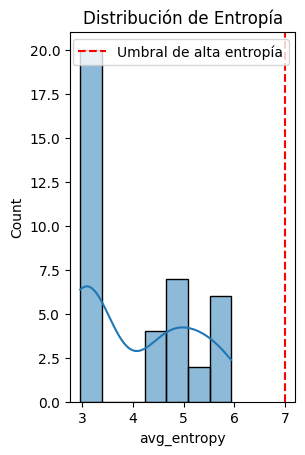

In [80]:
plt.subplot(1, 2, 2)
sns.histplot(df['avg_entropy'].dropna(), kde=True)
plt.axvline(x=7.0, color='r', linestyle='--', label='Umbral de alta entropía')
plt.title('Distribución de Entropía')
plt.legend()

## Preprocesamiento

In [81]:
#Seleccionar solo características numéricas
numerical_features = ['file_size', 'number_of_sections', 'imported_dlls_count', 
                    'imported_functions_count', 'days_since_compile', 'avg_entropy', 
                    'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']

In [82]:
#Manejar valores faltantes con la mediana
df_clean = df[numerical_features].copy()
df_clean = df_clean.fillna(df_clean.median())

In [83]:
print(f"Dataset limpio con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
print("Columnas seleccionadas:", numerical_features)

Dataset limpio con 39 filas y 10 columnas.
Columnas seleccionadas: ['file_size', 'number_of_sections', 'imported_dlls_count', 'imported_functions_count', 'days_since_compile', 'avg_entropy', 'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']


In [84]:
#Normalización/Estandarización
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_clean),
    columns=df_clean.columns
)

In [85]:
print("Dataset escalado (primeras 5 filas):")
print(df_scaled.head())

Dataset escalado (primeras 5 filas):
   file_size  number_of_sections  imported_dlls_count  \
0  -0.514453            0.398015            -0.592116   
1  -0.489245           -1.542308             0.727456   
2  -0.514453            0.398015            -0.592116   
3  -0.514453            0.398015            -0.592116   
4  -0.514453            0.398015            -0.592116   

   imported_functions_count  days_since_compile  avg_entropy  max_entropy  \
0                 -0.575737            0.779557    -0.875835    -0.917170   
1                 -0.262176           -1.242774     0.734980     0.290932   
2                 -0.575737            0.779557    -0.875866    -0.917170   
3                 -0.575737            0.779557    -0.883406    -0.917170   
4                 -0.575737            0.779557    -0.870371    -0.917170   

     is_dll    is_exe  suspicious_dll_count  
0 -0.383482  0.383482              -0.32806  
1 -0.383482  0.383482               1.80433  
2 -0.383482  0.3834

In [86]:
df_clean.to_csv('datasets/malware_dataset_clean.csv', index=False)

In [87]:
print("\nPreprocesamiento completado. Dataset guardado:")
print("* malware_dataset_clean.csv: Dataset limpio con características numéricas")


Preprocesamiento completado. Dataset guardado:
* malware_dataset_clean.csv: Dataset limpio con características numéricas


# Implementación del modelo

In [88]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm

In [89]:
#Carga del dataset limpio
df_clean = pd.read_csv('datasets/malware_dataset_clean.csv')
print(f"Dataset cargado con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas")

Dataset cargado con 39 filas y 10 columnas


In [90]:
#Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
X_df = pd.DataFrame(X_scaled, columns=df_clean.columns)

## Funciones

In [91]:
#Función para visualizar el método del codo
def plotElbowMethod(X, max_k=10, title="Método del Codo para K-means"):
    inertias = []
    K_range = range(1, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return inertias

In [127]:
#Función para visualizar la silueta detallada para un k específico
def plotSilhouetteAnalysis(X, kmeans_opt, agglomerative_opt):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    kmeans = KMeans(n_clusters=kmeans_opt, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(X)
    silhouette_avg_kmeans = silhouette_score(X, cluster_labels_kmeans)
    sample_silhouette_values_kmeans = silhouette_samples(X, cluster_labels_kmeans)
    
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=agglomerative_opt)
    cluster_labels_agg = agg.fit_predict(X)
    silhouette_avg_agg = silhouette_score(X, cluster_labels_agg)
    sample_silhouette_values_agg = silhouette_samples(X, cluster_labels_agg)
    
    # Plot K-means silhouette
    y_lower = 10
    for i in range(kmeans_opt):
        ith_cluster_silhouette_values = sample_silhouette_values_kmeans[cluster_labels_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / kmeans_opt)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title(f"Análisis de Silhouette para K-means (k={kmeans_opt})")
    ax1.set_xlabel("Coeficiente de Silhouette")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    
    # Plot Agglomerative silhouette
    y_lower = 10
    for i in range(agglomerative_opt):
        ith_cluster_silhouette_values = sample_silhouette_values_agg[cluster_labels_agg == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / agglomerative_opt)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax2.set_title(f"Análisis de Silhouette para Agglomerative (k={agglomerative_opt})")
    ax2.set_xlabel("Coeficiente de Silhouette")
    ax2.set_ylabel("Etiqueta del Cluster")
    ax2.axvline(x=silhouette_avg_agg, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xlim([-0.1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg_kmeans, silhouette_avg_agg

In [119]:
#Función para visualizar el dendrograma (para Agglomerative Clustering)
def plotDendrogram(X, max_d=None):
    # Crear un dendrograma
    linked = linkage(X, 'ward')
    
    plt.figure(figsize=(12, 8))
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=True,
                truncate_mode='level', 
                p=5)
    
    if max_d:
        plt.axhline(y=max_d, c='k', linestyle='--', label=f'Distancia de corte = {max_d}')
        plt.legend()
    
    plt.title('Dendrograma Jerárquico')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
    plt.show()

In [94]:
#Función para visualizar resultados de clustering
def plotClusteringResults(X, k_kmeans, k_agg):
    # Crear nuevos modelos con los k óptimos
    kmeans = KMeans(n_clusters=k_kmeans, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    agg = AgglomerativeClustering(n_clusters=k_agg)
    agg_labels = agg.fit_predict(X)
    
    # Aplicar PCA para visualizar en 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Visualizar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
    ax1.set_title(f'Clusters K-means (k={k_kmeans})')
    ax1.set_xlabel('Componente Principal 1')
    ax1.set_ylabel('Componente Principal 2')
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
    ax1.add_artist(legend1)
    
    # Agglomerative
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', s=50, alpha=0.8)
    ax2.set_title(f'Clusters Agglomerative (k={k_agg})')
    ax2.set_xlabel('Componente Principal 1')
    ax2.set_ylabel('Componente Principal 2')
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
    ax2.add_artist(legend2)
    
    plt.tight_layout()
    plt.show()
    
    return kmeans_labels, agg_labels

## Método del codo


Aplicación del método del codo para K-means:


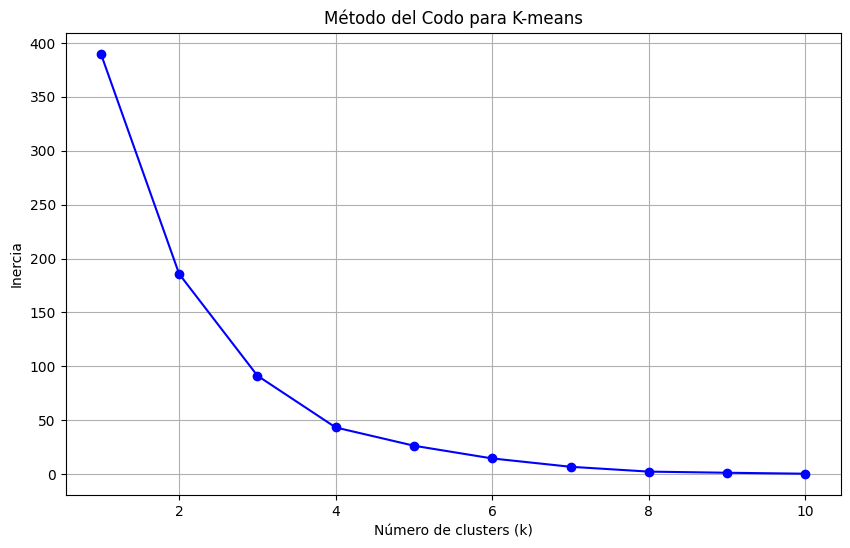

In [95]:
#Aplicar el método del codo para K-means
print("\nAplicación del método del codo para K-means:")
inertias = plotElbowMethod(X_scaled, max_k=10)

El método del codo muestra un valor optimo al rededor de los 4 clusters.

In [109]:
kmeans_opt = 4

## Dendograma


Visualización del dendrograma para Agglomerative Clustering:


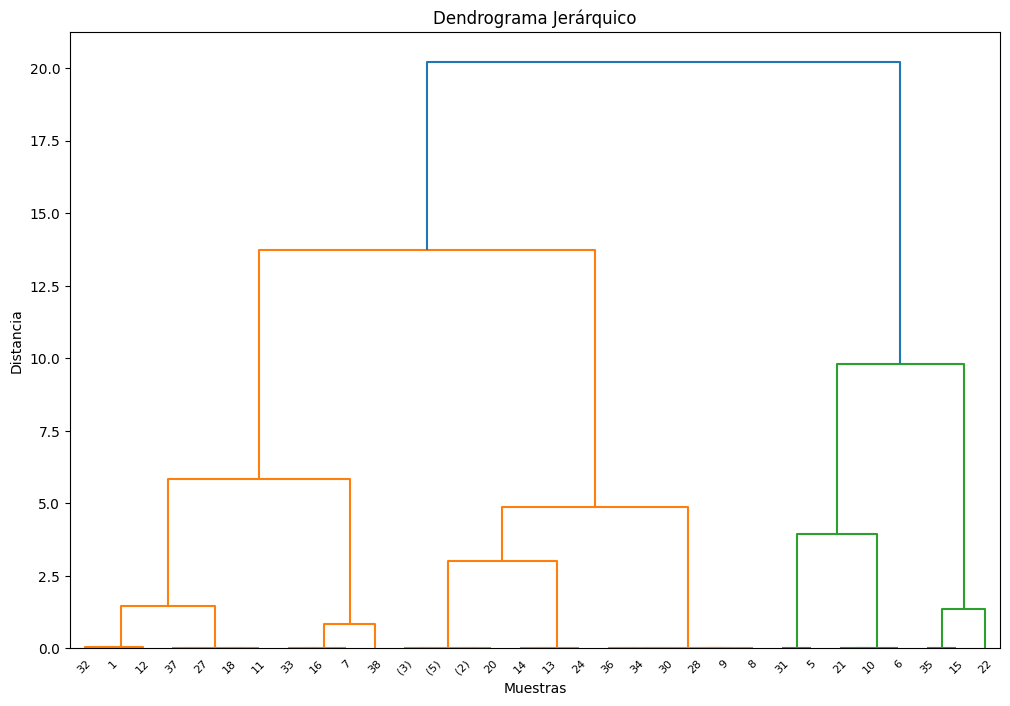

In [121]:
print("\nVisualización del dendrograma para Agglomerative Clustering:")
plotDendrogram(X_scaled)

Para el método aglomerativo podemos observar 3 grupos grandes, pero el grupo naranja puede ser separado en 2 subgrupos, por lo que se decidio que el número optimo es 4.

In [126]:
agglomerative_opt = 4

## Análisis de Silhouette para los k óptimos


Análisis detallado de Silhouette para los k óptimos:


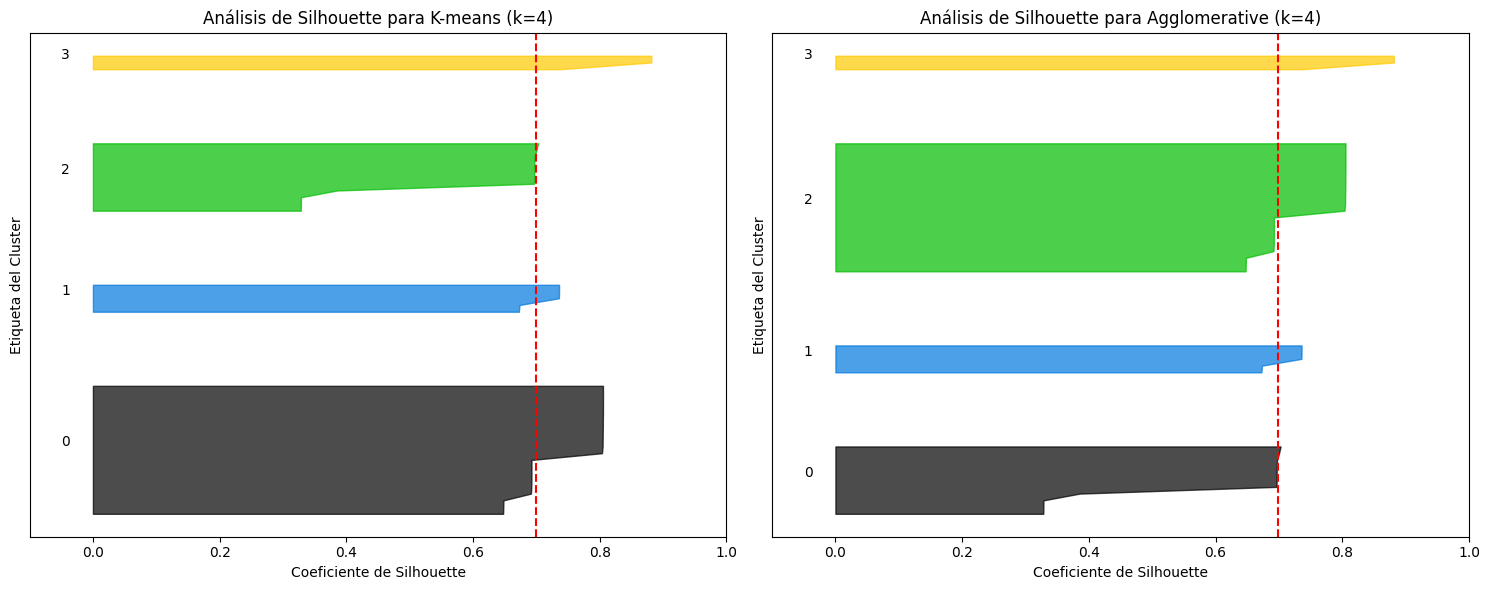

Coeficiente de Silhouette para K-means (k=4): 0.6988
Coeficiente de Silhouette para Agglomerative (k=4): 0.6988


In [128]:
print("\nAnálisis detallado de Silhouette para los k óptimos:")
sil_kmeans, sil_agg = plotSilhouetteAnalysis(X_scaled, kmeans_opt, agglomerative_opt)
print(f"Coeficiente de Silhouette para K-means (k={kmeans_opt}): {sil_kmeans:.4f}")
print(f"Coeficiente de Silhouette para Agglomerative (k={agglomerative_opt}): {sil_agg:.4f}")

Se puede observar que el coeficiente se encuentra en 0.6988, lo cual indica una buena separación entre clusters

## Clustering


Visualición de resultados de clustering:


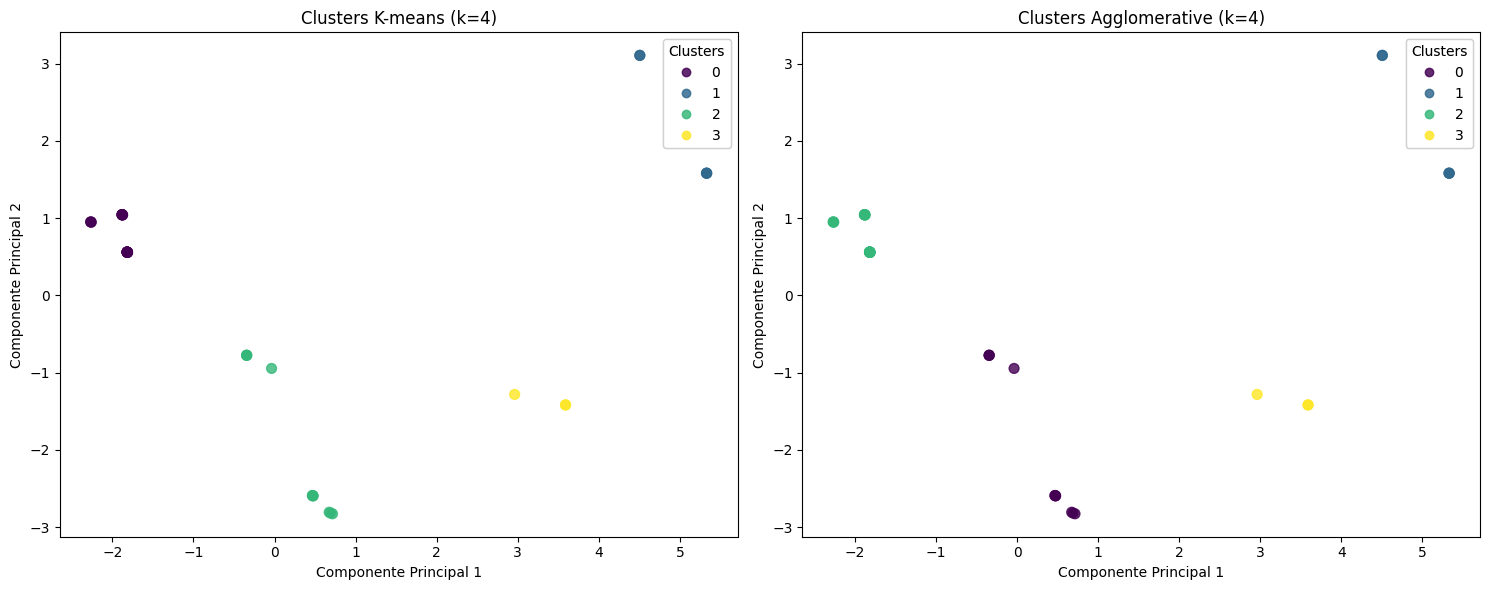

In [129]:
print("\nVisualición de resultados de clustering:")
kmeans_labels, agg_labels = plotClusteringResults(X_scaled, kmeans_opt, agglomerative_opt)

A pesar del resultado de obtenido en Silhouette, podemos observar que un cluster tiene demasiada distancia entre varios de sus elementos, por lo que puede ser posible generar un nuevo cluster.

In [145]:
kmeans_opt = 5
agglomerative_opt = 5


Análisis detallado de Silhouette para los nuevos k óptimos:


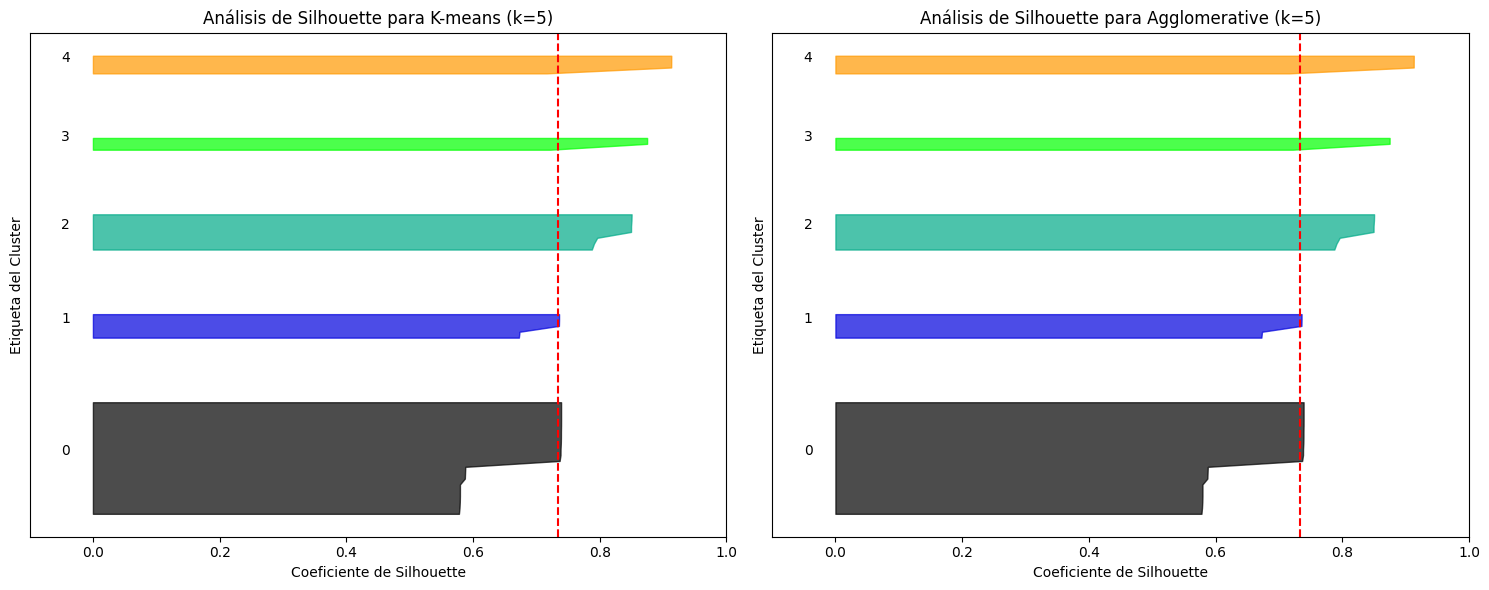

Coeficiente de Silhouette para K-means (k=5): 0.7336
Coeficiente de Silhouette para Agglomerative (k=5): 0.7336


In [146]:
print("\nAnálisis detallado de Silhouette para los nuevos k óptimos:")
sil_kmeans, sil_agg = plotSilhouetteAnalysis(X_scaled, kmeans_opt, agglomerative_opt)
print(f"Coeficiente de Silhouette para K-means (k={kmeans_opt}): {sil_kmeans:.4f}")
print(f"Coeficiente de Silhouette para Agglomerative (k={agglomerative_opt}): {sil_agg:.4f}")

Se puede ver una mejora significativa en el coeficiente de Silhouette, por lo que se utilizaran 5 clusters.

NOTA: se experimentó con un valor mayor de clusters, pero esto incurre en un sobreajusta, por lo que el número optimo es 5.


Visualición de resultados de clustering:


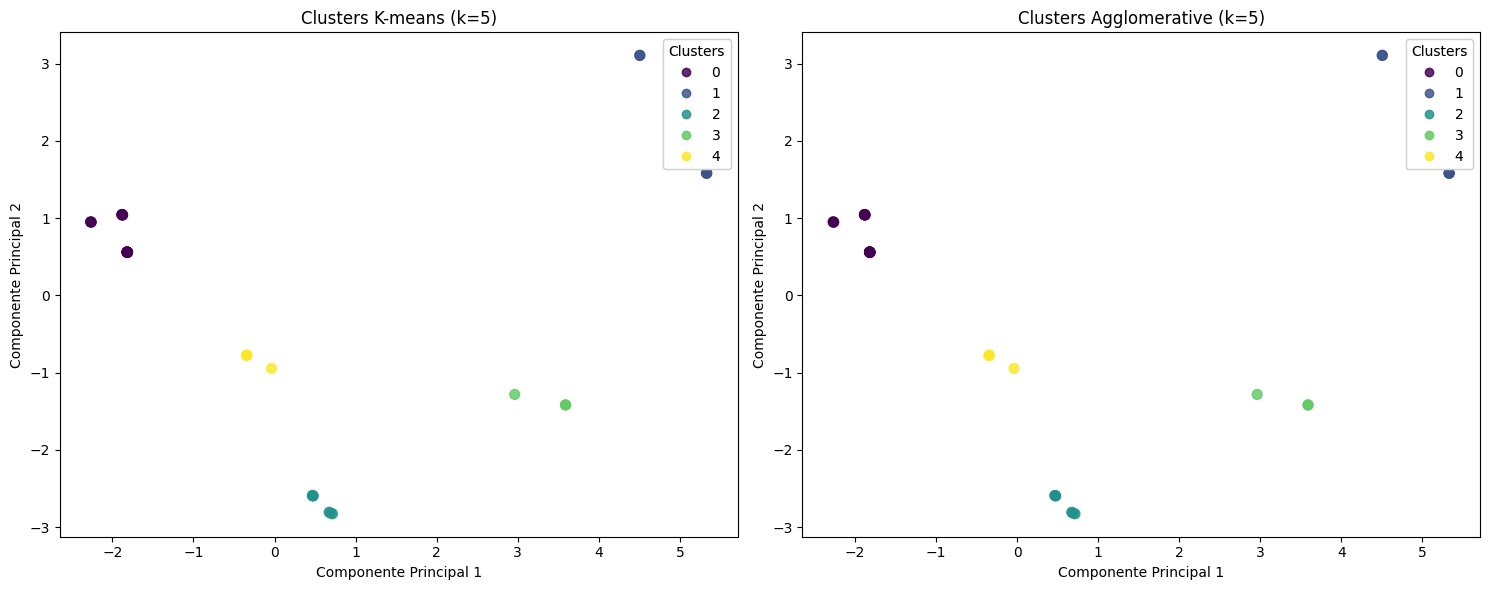

In [147]:
print("\nVisualición de resultados de clustering:")
kmeans_labels, agg_labels = plotClusteringResults(X_scaled, kmeans_opt, agglomerative_opt)

In [148]:
#Agregar etiquetas de cluster al dataset original
df_results = df_clean.copy()
df_results['kmeans_cluster'] = kmeans_labels
df_results['agg_cluster'] = agg_labels

In [149]:
#Guardar resultados
df_results.to_csv('datasets/malware_clustering_results.csv', index=False)
print("\nResultados guardados en 'datasets/malware_clustering_results.csv'")


Resultados guardados en 'datasets/malware_clustering_results.csv'


In [150]:
#Análisis de características por cluster
print("\nAnálisis de características por cluster")

# Para K-means
print("Análisis de clusters K-means:")
kmeans_cluster_analysis = df_results.groupby('kmeans_cluster').agg({
    'file_size': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(kmeans_cluster_analysis)


Análisis de características por cluster
Análisis de clusters K-means:
                count  number_of_sections  imported_dlls_count  \
kmeans_cluster                                                   
0                  20                 4.0             4.700000   
1                   5                 4.4             8.000000   
2                   7                 3.0             7.000000   
3                   3                 3.0             8.666667   
4                   4                 4.0             5.250000   

                imported_functions_count  avg_entropy  max_entropy  is_dll  \
kmeans_cluster                                                               
0                              58.700000     3.084514     5.961024       0   
1                             242.000000     5.572391     6.619027       5   
2                              85.000000     4.837620     6.241929       0   
3                             254.666667     5.702856     6.610556       0  

In [151]:
#Para Agglomerative
print("\nAnálisis de clusters Agglomerative:")
agg_cluster_analysis = df_results.groupby('agg_cluster').agg({
    'file_size': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(agg_cluster_analysis)


Análisis de clusters Agglomerative:
             count  number_of_sections  imported_dlls_count  \
agg_cluster                                                   
0               20                 4.0             4.700000   
1                5                 4.4             8.000000   
2                7                 3.0             7.000000   
3                3                 3.0             8.666667   
4                4                 4.0             5.250000   

             imported_functions_count  avg_entropy  max_entropy  is_dll  \
agg_cluster                                                               
0                           58.700000     3.084514     5.961024       0   
1                          242.000000     5.572391     6.619027       5   
2                           85.000000     4.837620     6.241929       0   
3                          254.666667     5.702856     6.610556       0   
4                           80.500000     4.444269     6.134475       0

## Comparación de los algoritmos

In [152]:
#Matriz de confusión entre los dos algoritmos
print("\nComparación entre clasificaciones de K-means y Agglomerative:")
confusion_matrix = pd.crosstab(df_results['kmeans_cluster'], df_results['agg_cluster'], 
                                rownames=['K-means'], colnames=['Agglomerative'])
print(confusion_matrix)


Comparación entre clasificaciones de K-means y Agglomerative:
Agglomerative   0  1  2  3  4
K-means                      
0              20  0  0  0  0
1               0  5  0  0  0
2               0  0  7  0  0
3               0  0  0  3  0
4               0  0  0  0  4


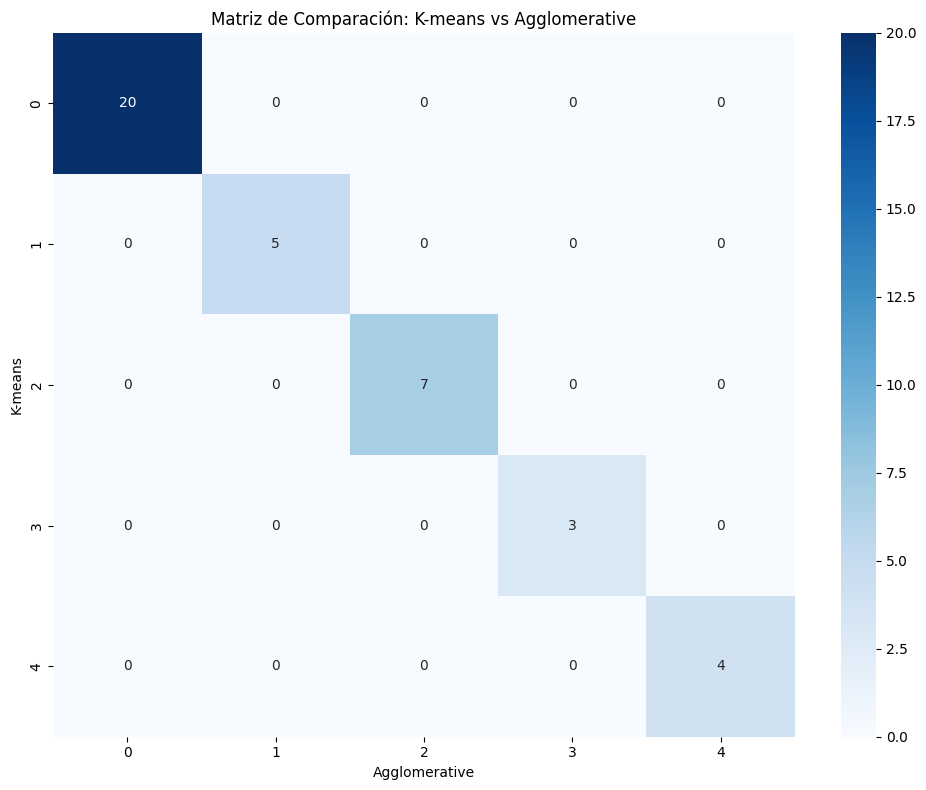

In [153]:
#Heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Comparación: K-means vs Agglomerative')
plt.tight_layout()
plt.show()

In [154]:
#Análisis de la diferencia en asignación de clusters
print("\nAnálisis de diferencia en asignación de clusters:")
df_results['same_cluster'] = df_results['kmeans_cluster'] == df_results['agg_cluster']
agreement_percentage = df_results['same_cluster'].mean() * 100
print(f"Porcentaje de acuerdo entre K-means y Agglomerative: {agreement_percentage:.2f}%")


Análisis de diferencia en asignación de clusters:
Porcentaje de acuerdo entre K-means y Agglomerative: 100.00%


In [156]:
#Características de muestras que difieren en la asignación de clusters
different_samples = df_results[~df_results['same_cluster']]
if len(different_samples) > 0:
    print(f"\nCaracterísticas promedio de muestras con diferente asignación ({len(different_samples)} muestras):")
    print(different_samples[numerical_features].mean())
    
    print("\nCaracterísticas promedio de muestras con la misma asignación:")
    print(df_results[df_results['same_cluster']][numerical_features].mean())
else:
    print("No hay muestras con diferente asignación.")


No hay muestras con diferente asignación.


## Creación de modelo

In [157]:
from dotenv import load_dotenv
import google.generativeai as genai

In [159]:
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
embeddings_path = 'datasets/embeddings.csv'

In [160]:
def prepare_text_features(df):
    return df.apply(lambda row: f"""
    Archivo con tamaño {row['file_size']} bytes, 
    con {row['number_of_sections']} secciones, 
    {row['imported_dlls_count']} DLLs importadas,
    {row['imported_functions_count']} funciones importadas,
    {row['days_since_compile']} días desde compilación,
    entropía promedio de {row['avg_entropy']:.2f},
    entropía máxima de {row['max_entropy']:.2f},
    {'es DLL' if row['is_dll'] else 'no es DLL'},
    {'es EXE' if row['is_exe'] else 'no es EXE'},
    con {row['suspicious_dll_count']} DLLs sospechosas
    """, axis=1)

In [169]:
def get_embeddings(texts):
    print("Getting embeddings...")
    if os.path.exists(embeddings_path):
        print("Embeddings already exist, loading from file...")
        existing_embeddings = pd.read_csv(embeddings_path)
        #return a numpy array
        return np.array(existing_embeddings)

    print("No embeddings found, generating new ones...")
    model = 'models/embedding-001'
    embeddings = []
    
    for text in texts:
        result = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
        embeddings.append(result['embedding'])
    
    #save embeddings to csv
    pd.DataFrame(embeddings).to_csv(embeddings_path, index=False)
    return np.array(embeddings)

Getting embeddings...
Embeddings already exist, loading from file...


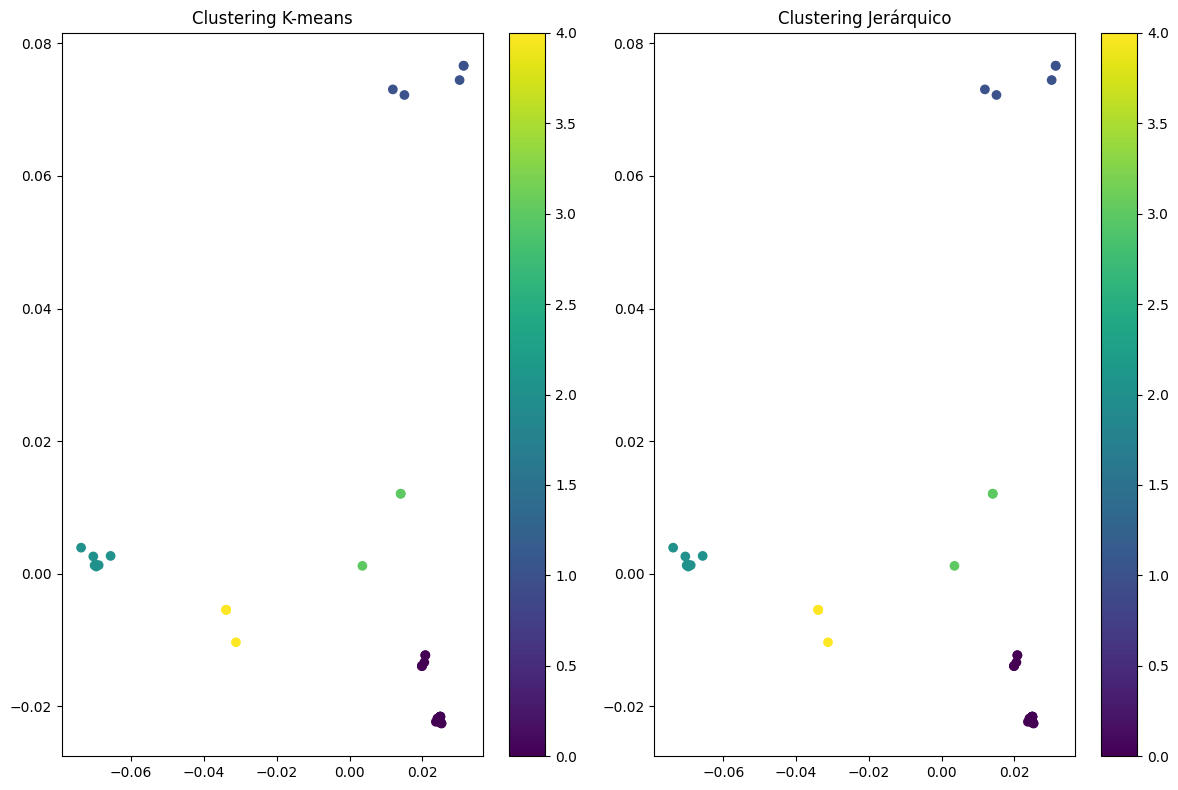

In [173]:
df = pd.read_csv('datasets/malware_clustering_results.csv')
    
#preparar textos para embeddings
texts = prepare_text_features(df)

#obtener embeddings
embeddings = get_embeddings(texts)

#reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
    
plt.figure(figsize=(12, 8))

#graficar clusters de K-means
plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=df['kmeans_cluster'], cmap='viridis')
plt.title('Clustering K-means')
plt.colorbar(scatter)

#graficar clusters jerárquicos
plt.subplot(1, 2, 2)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=df['agg_cluster'], cmap='viridis')
plt.title('Clustering Jerárquico')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()